In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Esse notebook tem o objetivo de implementar o TSMOM do  Moskowitz.

![Equação do TSMOM](images/tsmom_eq.jpeg)

Em resumo a equação final do TSMOM do Moskowitz tem 3 partes: 
- O cálculo do momento do ativo
- Poderação do peso no portifolio 
- Rendimento da estratégia

Cálculo do Momento: Calcula-se o retorno do periodo desejado (no caso da imagem os ultimos 12 meses), e com o retorno e mãos retira-se o sinal, tomando assim uma posição de vendido ou comprado.

O peso no portifolio: Risco buscado no investimento (no caso da imagem 20%), dividido pelo desvio padrão exponencial.



In [2]:
df = pd.read_csv("data.csv")
df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.drop('date', axis=1)

close_columns = []
high_columns = []
low_columns = []
open_columns = []
volume_columns = []
open_int_columns = []

for i in df.columns:
    if "close" in i:
        close_columns.append(i)
    elif "high" in i:
        high_columns.append(i)
    elif "low" in i:
        low_columns.append(i)
    elif "open_int" in i:
        open_int_columns.append(i)
    elif "open" in i:
        open_columns.append(i)
    elif "volume" in i:
        volume_columns.append(i)
        
close_df = df[close_columns]
high_df = df[high_columns]
low_df = df[low_columns]
open_df = df[open_columns]
volume_df = df[volume_columns]
open_int_df = df[open_int_columns]

In [3]:
close_df.tail()

,AN_close,BN_close,CC_close,CN_close,CT_close,DA_close,DX_close,EC_close,EN_close,ES_close,...,ZU_close,ZW_close,ZZ_close,DT_close,HS_close,LX_close,NK_close,SP_close,UB_close,AX_close
date,,,,,,,,,,,,,,,,,,,,,
2019-06-17,68.69,125.91,2479.0,74.680,66.42,16.84,97.050,97.900,7561.25,2896.25,...,52.17,539.50,83.050,171.58,26975.0,7292.5,21095.0,2896.3,134.11,12082.0
2019-06-18,68.92,126.11,2500.0,74.865,66.82,16.86,97.155,97.900,7673.50,2926.25,...,54.11,531.50,81.475,172.76,27269.0,7386.0,21210.0,2926.2,134.61,12321.5
2019-06-19,69.08,127.19,2513.0,75.375,67.16,16.98,96.580,97.995,7702.00,2933.50,...,53.97,522.25,81.625,172.53,27968.0,7331.5,21310.0,2933.4,134.45,12298.0
2019-06-20,69.40,127.48,2446.0,75.925,65.96,17.18,96.140,98.045,7772.75,2960.00,...,57.07,526.50,79.250,172.59,28338.0,7363.5,21460.0,2960.0,134.43,12361.5
2019-06-21,69.44,127.85,2502.0,75.830,65.56,17.09,95.720,98.015,7751.50,2950.50,...,57.43,526.00,76.250,172.08,28255.0,7318.0,21190.0,2950.6,134.26,12270.0


## Signals

In [4]:
# daily data
returns_daily = close_df.pct_change().dropna()
vol_daily = returns_daily.ewm(adjust=True, com=60, min_periods=0).std().dropna()

#monthly data
returns_monthly = close_df.pct_change(20).dropna().resample('BM').last().ffill()
vol_monthly = (np.sqrt(261)*vol_daily).resample('BM').last().ffill()

In [5]:
vol_monthly.head()

,AN_close,BN_close,CC_close,CN_close,CT_close,DA_close,DX_close,EC_close,EN_close,ES_close,...,ZU_close,ZW_close,ZZ_close,DT_close,HS_close,LX_close,NK_close,SP_close,UB_close,AX_close
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,0.105042,0.062671,0.340395,0.079590,0.208741,0.117408,0.057450,0.006805,0.273889,0.171174,...,0.376478,0.145714,0.381138,0.073597,0.217934,0.083019,0.097903,0.171116,0.032165,0.126013
1999-07-30,0.102485,0.092296,0.367361,0.053053,0.248199,0.228037,0.072208,0.004424,0.272543,0.151698,...,0.301792,0.282767,0.413881,0.073126,0.311318,0.224145,0.188760,0.151480,0.041537,0.218992
1999-08-31,0.100980,0.087018,0.317635,0.065784,0.233056,0.262282,0.082101,0.005188,0.283183,0.173361,...,0.290636,0.255201,0.383358,0.071736,0.313992,0.221060,0.191588,0.173167,0.040713,0.222227
1999-09-30,0.098992,0.082781,0.351501,0.061236,0.229098,0.270938,0.080132,0.005897,0.294703,0.186051,...,0.270916,0.260535,0.352725,0.075146,0.293303,0.209225,0.184466,0.186178,0.043353,0.216286
1999-10-29,0.101794,0.082981,0.329411,0.055821,0.218192,0.297339,0.086932,0.006833,0.308855,0.217140,...,0.377323,0.247127,0.351677,0.075506,0.329189,0.212675,0.189809,0.217070,0.043262,0.213240


### Parkinson's Volatility
estimating vol with high and low prices
![Número de Parkinson](images/parkinson_vol.png)

In [6]:
def parkinson_vol(high_df, low_df, period=60):
    x = np.log(np.divide(high_df, low_df)) ** 2
    x.columns = [x[0:3] + "pv" for x in x.columns]
    
    pv = x.copy()

    
    const = 1 / (4 * period * np.log(2))
    
    pv.iloc[:period,:] = np.nan
        
    for row in range(period, len(high_df)):
        pv.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return pv

## Garman and Klass volatility
estimating vol with close, open, low and prices.

![Garman Klass vol](images/garman-klass_vol.png)

In [7]:
def garman_klass_vol(high_df, low_df, close_df, open_df, period=60):
    
    x_oc = np.log(np.divide(open_df, close_df.shift(-1))) ** 2
    x_hl = (1/2)*(np.log(np.divide(high_df, low_df))) ** 2
    x_co = - (2 * np.log(2) - 1)* (np.log(np.divide(close_df, open_df))**2)
    
    x = x_hl + x_co.values
    
    x.columns = [x[0:3] + "gk" for x in x.columns]
    
    gk = x.copy()
    
    const = 1/period
    
    gk.iloc[:period,:] = np.nan
    
    for row in range(period, len(high_df)):
        gk.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return gk

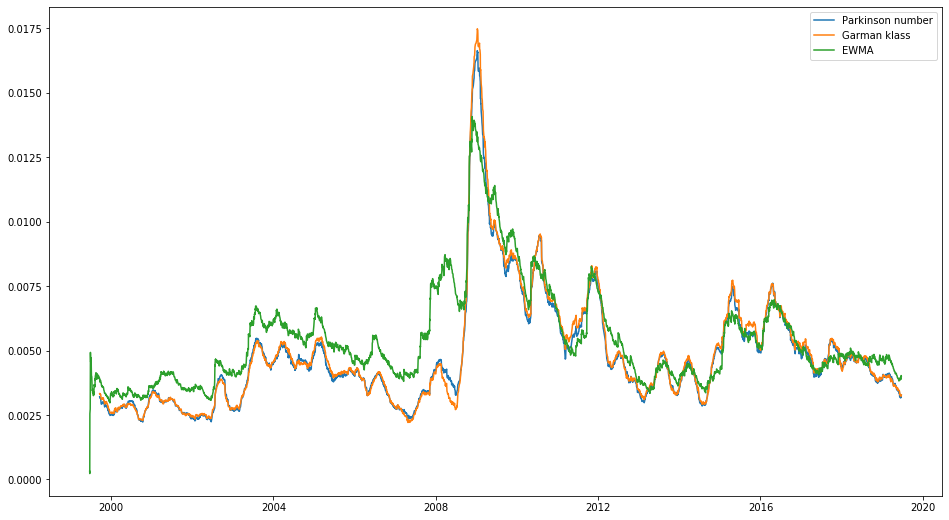

In [8]:
pv_df = parkinson_vol(high_df, low_df)
gk_df = garman_klass_vol(high_df, low_df, close_df, open_df)

plt.figure(figsize=(16,9))

plt.plot(pv_df.iloc[:,3], label= "Parkinson number")
plt.plot(gk_df.iloc[:,3], label="Garman klass")
plt.plot(vol_daily.iloc[:,3], label="EWMA")

plt.legend()

plt.show()

In [9]:
pv_monthly = (np.sqrt(261)*pv_df).resample('BM').last().ffill()
gk_monthly = (np.sqrt(261)*gk_df).resample('BM').last().ffill()

## Machine Learning Forecast

In [195]:
from sklearn.linear_model import LinearRegression
from sklearn.tree                   import DecisionTreeRegressor
import xgboost as xgb

In [295]:
def ml_signal(model, returns, lags=[1, 3, 6, 12]):
    """
    Return predict and signal construction (long or short)
    """
    signal = []
    
    for i in returns.columns:
        # converting Series to DataFrame to do the feature engineering
        stock = pd.DataFrame(returns[i].copy())
        
        # renaming target variable
        stock.columns = ["y"]
        
        # adding lagged columns
        for i in lags:
            stock["lag_{}".format(i)] = stock.y.shift(i)
            
        y = stock[:-1].dropna().y                   # target
        X = stock[:-1].dropna().drop(['y'], axis=1) # features
        
        model.fit(X, y)
        
        X_pred = []
        for i in lags:
            X_pred.append(stock["lag_" + str(i)][-i])
        
        y_pred = model.predict([X_pred])
        
        sign = np.where(y_pred/stock.iloc[-1] - 1 > 0, 1, -1)
        
        signal.append(sign[0])
        
    return signal

In [302]:
lr = LinearRegression()
dtr = DecisionTreeRegressor()

signal = ml_signal(dtr, returns_monthly[12:36])

In [309]:
def absolute_percentage_error(y_true, y_pred): 
    return np.abs((y_true - y_pred) / y_true)* 100

date = 36

true = pd.DataFrame(np.array(close_df))
true_returns = true.pct_change()

pred = np.array(signal)

result = pd.DataFrame()
result["True"] = np.where(true_returns.iloc[date] > 0, 1, -1)
result["Pred"] = pred
result["Mean Abs Error"] = absolute_percentage_error(result["True"], result["Pred"])

result.head()

,True,Pred,Mean Abs Error
0,1,-1,200.0
1,-1,-1,0.0
2,-1,-1,0.0
3,1,-1,200.0
4,-1,-1,0.0


## Algorithm

![Generalização do TSMOM](images/ts_eq.png)

Onde $X_t$ é o sinal de predição, que esta entre -1 e 1

In [293]:
def signal(df, date, passive, method):
        
    num_assets = len(df.iloc[-1])
    signal = []
    
    if method == "momentum":
        
        returns = df.pct_change(20 * 12).resample('BM').last().ffill()[:date]
        
        if passive:
            signal = np.ones(num_assets)
        else:
            signal = np.where(returns.iloc[-1] > 0, 1, -1)
            
    elif method == "momentum_lagged":
        
        returns_12 = df.pct_change(21 * 12).resample('BM').last().ffill()[:date]
        
        returns_6 = df.pct_change(21 * 6).resample('BM').last().ffill()[:date]
        
        returns_3 = df.pct_change(21 * 3).resample('BM').last().ffill()[:date]
        
        momentum_mean = (returns_12.iloc[-1] + returns_6.iloc[-1] + returns_3.iloc[-1]) / 3
        
        
        if passive:
            signal = np.ones(num_assets)
        else:
            signal = np.where(momentum_mean > 0, 1, -1)
            
    elif method == "linear_regression":
        returns = df.pct_change(20).resample('BM').last().ffill()[:date].cumprod()
        
        lr = LinearRegression()
        
        signal = ml_signal(lr, returns)
        
    elif method == "decision_tree":
        returns = df.pct_change(20).resample('BM').last().ffill()[:date].cumprod()
        
        dtr = DecisionTreeRegressor()
        
        signal = ml_signal(dtr, returns)
                
    return signal
    
def tsmom (df,returns_monthly, vol_monthly,date, method = 'momentum', risk=0.4, passive=False, momentum_window=12):
    
    position = signal(df, date, passive, method)
        
    weights = (risk / vol_monthly.iloc[date-1])
    
    weights /= len(weights)
    
    portfolio = position * weights
    
    return (1+np.dot(portfolio, returns_monthly.iloc[date]))

# Backtesting and plot functions

In [278]:
def plot_backtesting(returns_model, returns_baseline, label_model, label_baseline, title):

    plt.figure(figsize=(16, 9))

    plt.plot(100*returns_model.cumprod(), label=label_model, color='blue')
    plt.plot(100*returns_baseline.cumprod(),
             label=label_baseline, color='red')

    plt.yscale('log')
    plt.legend()
    plt.title(title)
    plt.show()
    
    passive_return = float((returns_baseline.cumprod().iloc[-1] - 1)*100)
    tsmom_return = float((returns_model.cumprod().iloc[-1] - 1)*100)

    print('Passive ', label_baseline, ' return: ', round(passive_return,2), '%,',
         " Annualized: ", round((((100+passive_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')

    print('TSMOM ', label_model, ' return: ', round(tsmom_return,2), "%,",
         " Annualized: ", round((((100+tsmom_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')
    
def backtesting(close_df, vol_monthly, start_date, years, method, plot=True):

    returns_model = []  
    returns_baseline = []
    start = start_date
    years = years
    end = 12*(int(start/12) + years)

    for i in range(start, end):

        returns_model.append(tsmom(close_df, returns_monthly, vol_monthly, i, method))

        returns_baseline.append(tsmom(close_df, returns_monthly,
                                           vol_monthly, i, passive=True))

    returns_model = pd.DataFrame(returns_model)
    returns_baseline = pd.DataFrame(returns_baseline)

    returns_model.index = returns_monthly.iloc[start:end].index
    returns_baseline.index = returns_monthly.iloc[start:end].index

    if plot:
        plot_backtesting(returns_model, returns_baseline, method, "Long only", "Cumulative returns")

## Classic TSMOM

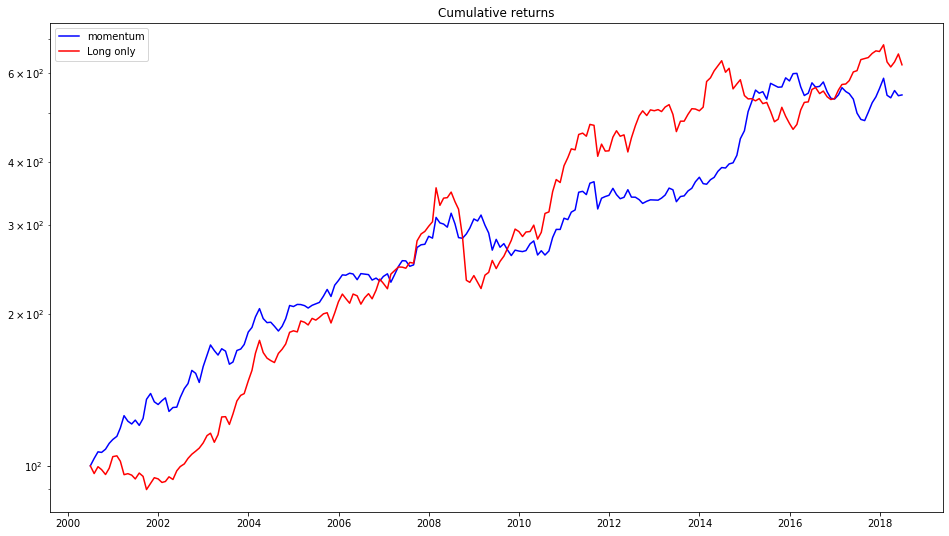

Passive Long only return: 522.68%, Annualized: 10.1%
TSMOM momentum return: 442.73%, Annualized: 9.31%


In [279]:
backtesting(close_df, vol_monthly, start_date= 11, years=19, method="momentum", plot=True)

## Parkinson vol

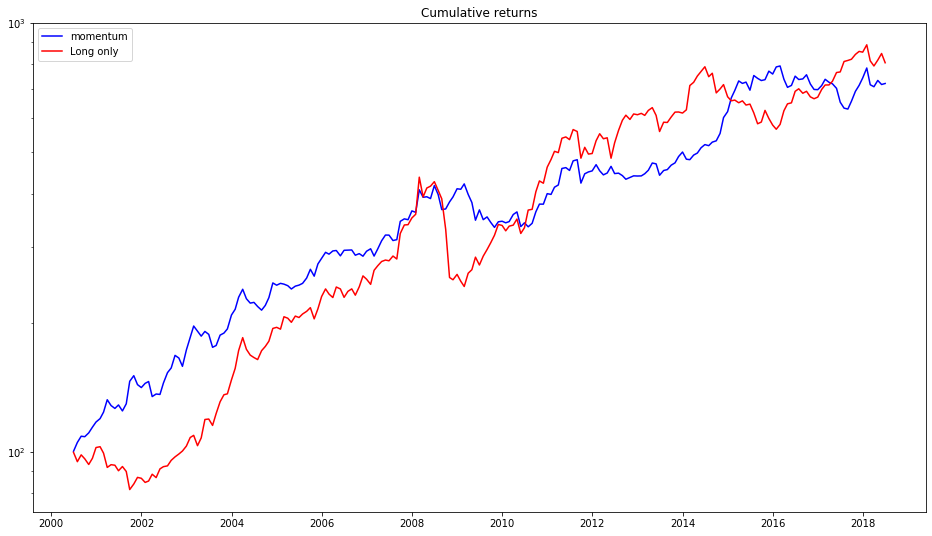

Passive Long only return: 706.96%, Annualized: 11.62%
TSMOM momentum return: 621.95%, Annualized: 10.96%


In [280]:
backtesting(close_df, pv_monthly, start_date= 11, years=19, method="momentum", plot=True)

## Garman klass vol

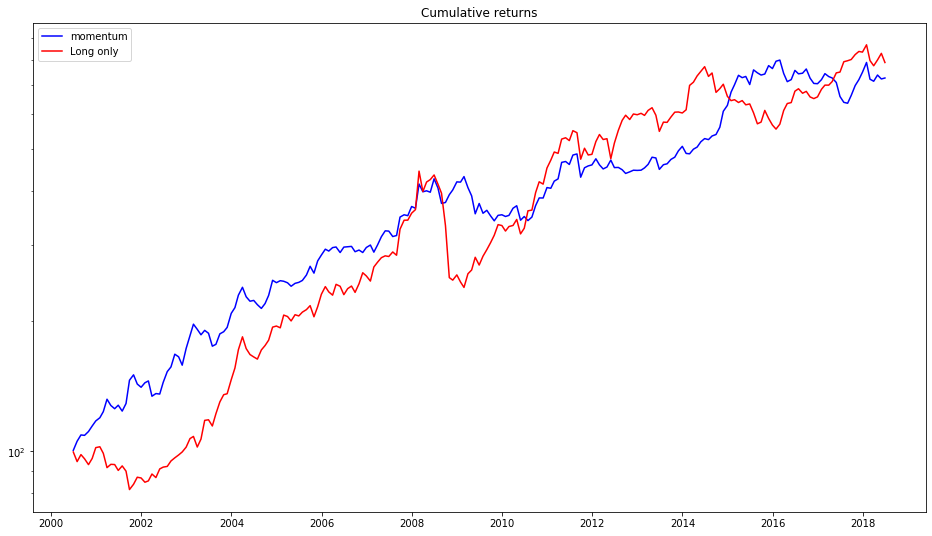

Passive Long only return: 690.74%, Annualized: 11.5%
TSMOM momentum return: 628.26%, Annualized: 11.02%


In [281]:
backtesting(close_df, gk_monthly, start_date= 11, years=19, method="momentum", plot=True)

# Multiple mometums as signals

## Classic mometum vol

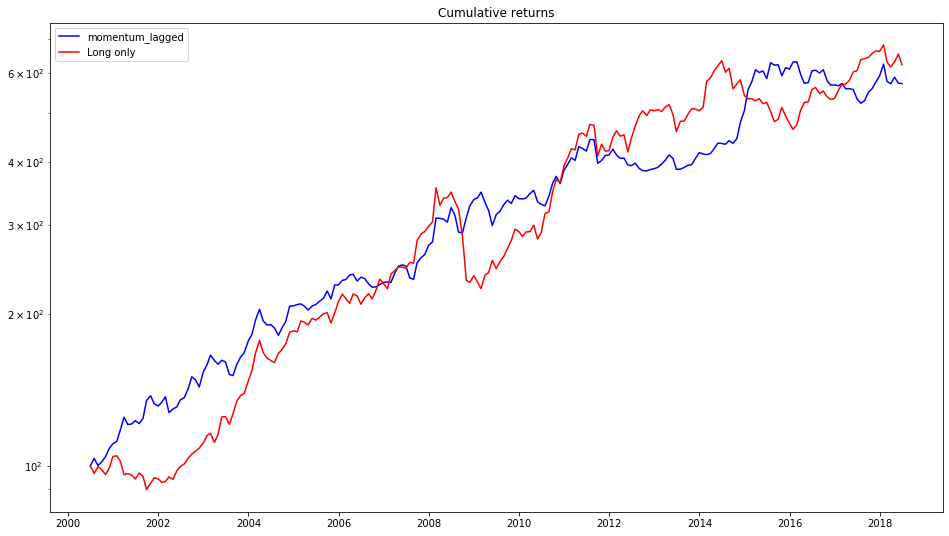

Passive Long only return: 522.68%, Annualized: 10.1%
TSMOM momentum_lagged return: 471.4%, Annualized: 9.61%


In [282]:
backtesting(close_df, vol_monthly, start_date= 11, years=19, method="momentum_lagged", plot=True)

## Parkinson number

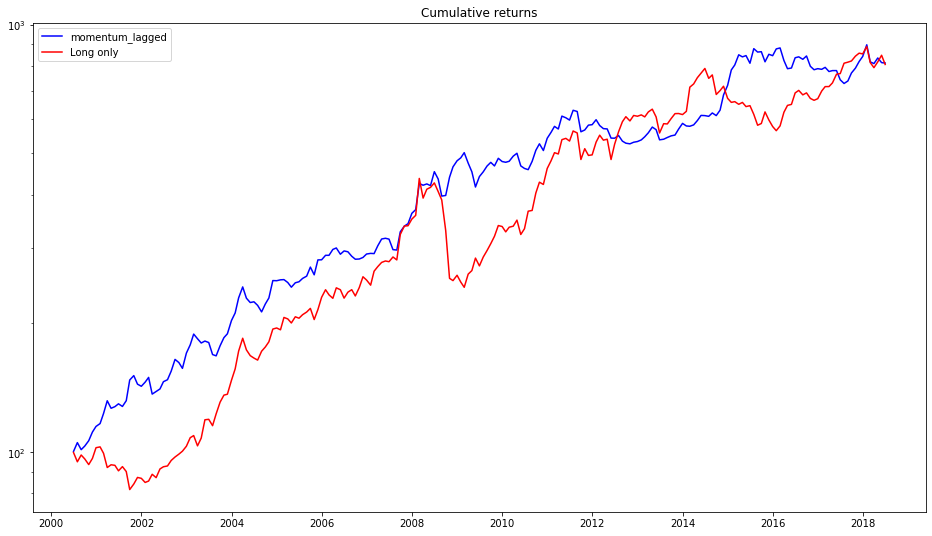

Passive Long only return: 706.96%, Annualized: 11.62%
TSMOM momentum_lagged return: 713.17%, Annualized: 11.66%


In [283]:
backtesting(close_df, pv_monthly, start_date= 11, years=19, method="momentum_lagged", plot=True)

## Garman Klass

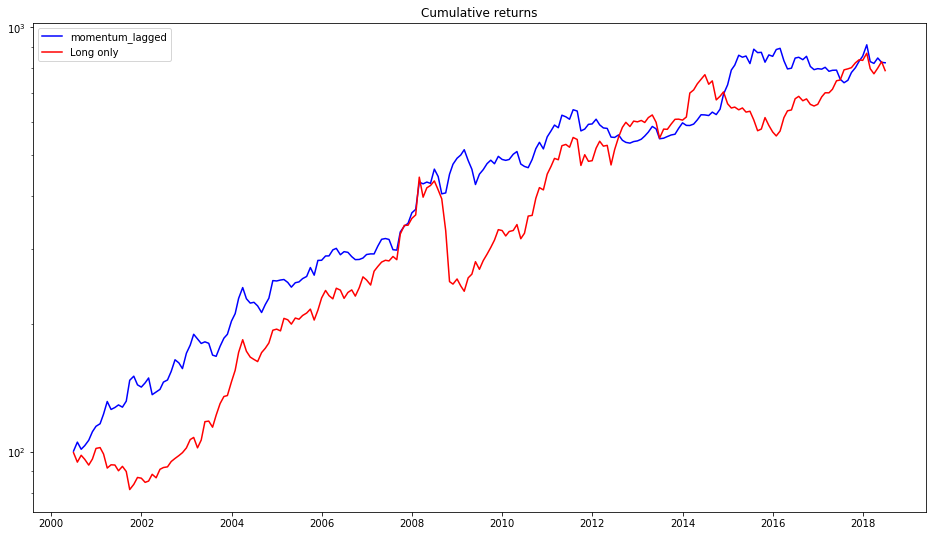

Passive Long only return: 690.74%, Annualized: 11.5%
TSMOM momentum_lagged return: 725.16%, Annualized: 11.75%


In [284]:
backtesting(close_df, gk_monthly, start_date= 11, years=19, method="momentum_lagged", plot=True)

# Machine Learning

## Linear Regression

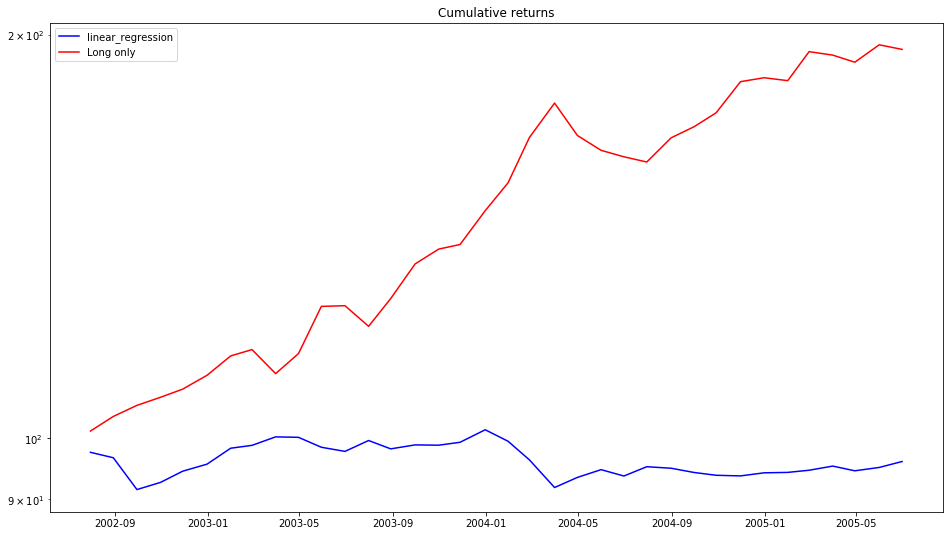

Passive Long only return: 95.0%, Annualized: 24.93%
TSMOM linear_regression return: -3.93%, Annualized: -1.33%


In [296]:
backtesting(close_df, vol_monthly, start_date= 36, years=3, method="linear_regression", plot=True)

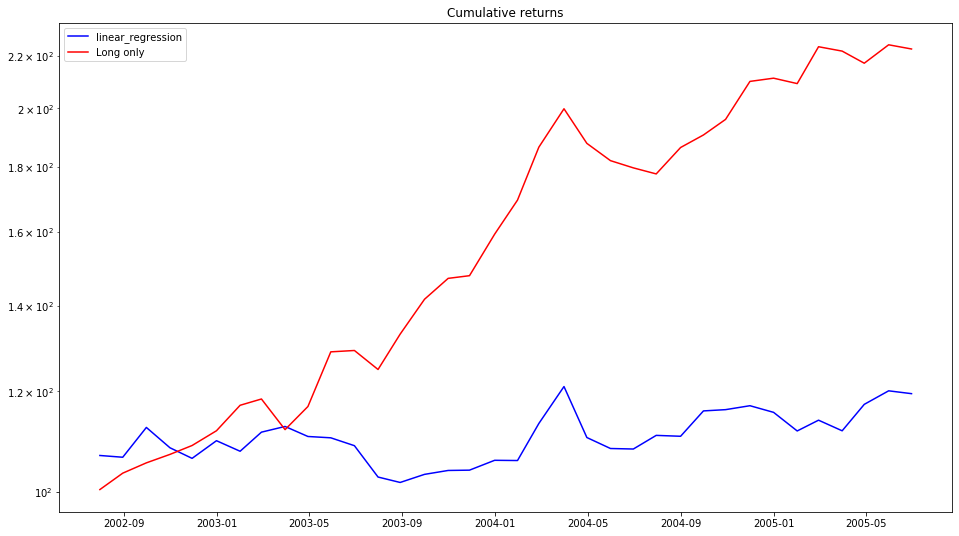

Passive Long only return: 122.67%, Annualized: 30.58%
TSMOM linear_regression return: 19.44%, Annualized: 6.1%


In [291]:
backtesting(close_df, pv_monthly, start_date= 36, years=3, method="linear_regression", plot=True)

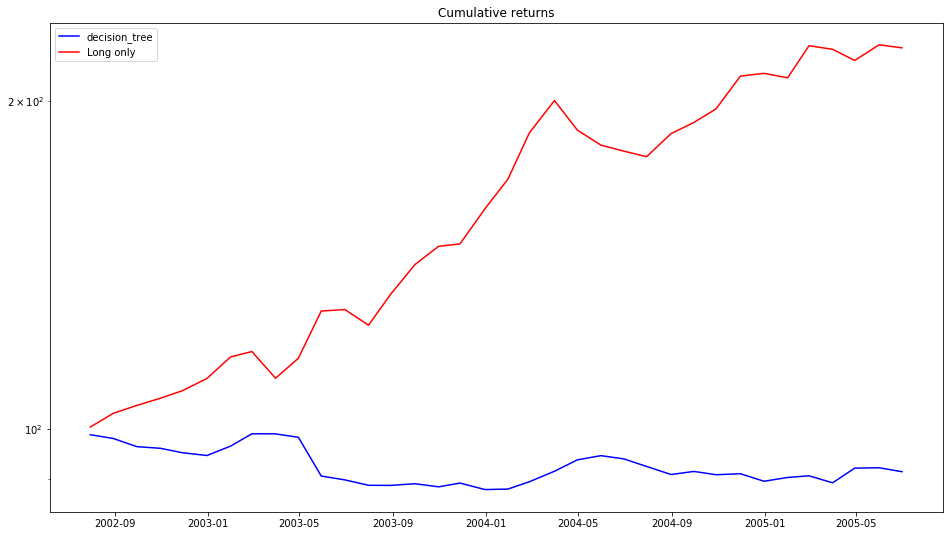

Passive Long only return: 123.52%, Annualized: 30.75%
TSMOM decision_tree return: -8.66%, Annualized: -2.97%


In [297]:
backtesting(close_df, gk_monthly, start_date= 36, years=3, method="decision_tree", plot=True)